In [1]:
%matplotlib inline


Basic neuroquery example: downloading a trained model and making a few queries
==============================================================================

This example shows basic neuroquery functionality:

- download a trained neuroquery model
- query it with some text
- have a look at the result: a brain map and a list of similar or related
    terms.

The model used here is the same as the one deployed on the neuroquery website
( https://neuroquery.saclay.inria.fr ), and this example shows how to easily
reproduce the website's functionality in a Python script.


Download the vocabulary and learned coefficients of a NeuroQuery model
----------------------------------------------------------------------



In [2]:
from neuroquery import datasets

neuroquery_data = datasets.fetch_neuroquery_model()
print(neuroquery_data)

/home/jerome/neuroquery_data/neuroquery_data/neuroquery_model


Load the NeuroQuery model
-------------------------



In [3]:
from neuroquery import text_to_brain

encoder = text_to_brain.TextToBrain.from_data_dir(neuroquery_data)

/home/jerome/workspace/scikit-learn/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Query the model and display the results
---------------------------------------



In [4]:
# taken from Wikipedia
query = "Aphasia is an inability to comprehend or formulate language"

response = encoder(query)
print(response.keys())

dict_keys(['z_map', 'raw_tfidf', 'smoothed_tfidf', 'similar_words', 'highlighted_text'])


The "z_map" entry of the results is a brain map showing the anatomical
regions that are most strongly associated with the query in the neuroimaging
literature. It is a `Nifti1Image` which can be saved, displayed, etc.



<class 'nibabel.nifti1.Nifti1Image'>


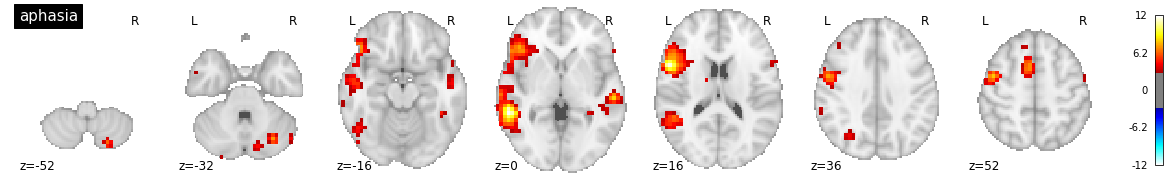

In [5]:
from nilearn import plotting

print(type(response["z_map"]))
plotting.plot_stat_map(
    response["z_map"], display_mode="z", title="aphasia", threshold=3.)

In [6]:
# Display the map on the cortical surface:
# (in a Jupyter notebook,
# `.open_in_browser()` can be ommitted to open an inline view)
plotting.view_img_on_surf(response["z_map"], threshold=3.).open_in_browser()

In [7]:
# Or open interactive viewer:
# (in a Jupyter notebook,
# `.open_in_browser()` can be ommitted to open an inline view)
plotting.view_img(response["z_map"], threshold=3.).open_in_browser()

"similar_words" is a DataFrame containing terms that are related to the
query. For each related terms, three numbers are provided.
"similarity" is the strength of the association between the term and the
query, according to co-occurrence statistics in the literature.



In [8]:
print("Most similar terms:\n")
print(response["similar_words"].sort_values(
    by="similarity", ascending=False).head())

Most similar terms:

          similarity  weight_in_brain_map  weight_in_query
aphasia     0.848526             0.000000         0.869341
language    0.522288            38.016342         0.494213
naming      0.060369             0.000000         0.000000
stroke      0.035536             0.000000         0.000000
picture     0.024700             0.000000         0.000000


"weight_in_brain_map" is the importance of the term in the brain map. It
depends both on the similarity with the query and on the strength of the link
between this term and brain activity. Terms that are similar to the query and
have a strong association with brain activity in the literature get a higher
weight.



In [9]:
print("\nMost important terms for brain map prediction:\n")
print(response["similar_words"].sort_values(
    by="weight_in_brain_map", ascending=False).head())


Most important terms for brain map prediction:

          similarity  weight_in_brain_map  weight_in_query
language    0.522288            38.016342         0.494213
speech      0.008177             2.014637         0.000000
left        0.003967             0.651356         0.000000
temporal    0.001526             0.522694         0.000000
motor       0.000979             0.490382         0.000000


"weight_in_query" is the importance of the term in the query itself. It
reflects the number of times each term appears in the query (reweighted so
that very common, uninformative words get a lower weight). For example, terms
that do not appear in the query get a "weight_in_query" of 0.



In [10]:
print("\nTerms recognized in the query:\n")
print(response["similar_words"].query("weight_in_query != 0").sort_values(
    by="weight_in_query", ascending=False).head())


Terms recognized in the query:

          similarity  weight_in_brain_map  weight_in_query
aphasia     0.848526             0.000000         0.869341
language    0.522288            38.016342         0.494213


Finally, "highlighted_text" contains the text of the query itself, with
markups that indicates which terms were recognized and used by the model
(usually terms related to neuroimaging):



In [11]:
print(response["highlighted_text"])

# `print_highlighted_text` can help display it in a terminal for debugging.

from neuroquery.tokenization import print_highlighted_text

print("\n")
print_highlighted_text(response["highlighted_text"])

<highlighted_text><extracted_phrase standardized_form="aphasia" in_model="false">Aphasia</extracted_phrase> is an inability to comprehend or formulate <extracted_phrase standardized_form="language" in_model="true">language</extracted_phrase></highlighted_text>


[Aphasia] is an inability to comprehend or formulate [language]


In [12]:
plotting.show()